# Laboration maskininlärning AI22

## 1.0 - Uppvärmning
recommender_test.ipynb

## 1.1 - Movielens full - EDA

In [2]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

y:\Skola\OOP\Skolarbete\AI-Erik-Johansson-OPA23\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# load in datasets
movies='data/large/movies.csv'
ratings='data/large/ratings.csv'

df_movies=pd.read_csv(movies, usecols=['movieId', 'title'], dtype={'movieId' : 'int32', 'title' : 'str'})
df_ratings=pd.read_csv(ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId':'int32', 'movieId':'int32', 'rating':'float32'})

### a)

In [4]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int32 
 1   title    86537 non-null  object
dtypes: int32(1), object(1)
memory usage: 1014.2+ KB


In [6]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0


In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 387.2 MB


In [50]:
top5_users = df_ratings["userId"].value_counts().index.tolist()[:5]
top5_user_ratings = df_ratings["userId"].value_counts().tolist()[:5]
df_ratings_per_user = pd.DataFrame({"userId": top5_users, "ratings": top5_user_ratings})
df_ratings_per_user

,userId,ratings
0,189614,33332
1,48766,9554
2,207216,9178
3,175998,9016
4,76618,8919


C:\Users\Erik\AppData\Local\Temp\ipykernel_2592\3943175986.py:5: FutureWarning: The provided callable <function median at 0x00000265D3F46B60> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  result = df_ratings_per_user.groupby(["userId"])["ratings"].aggregate(np.median).reset_index().sort_values("ratings", ascending=False)


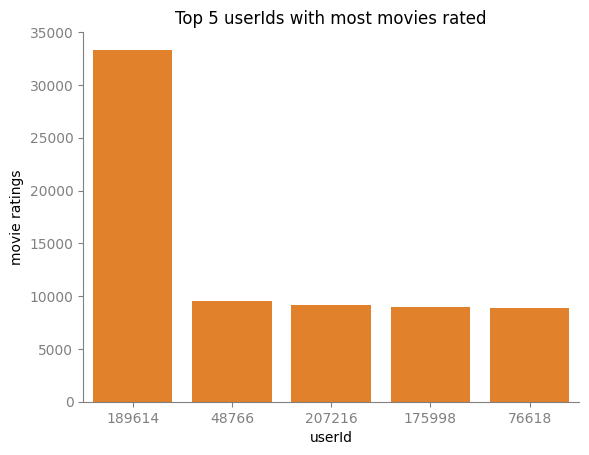

In [60]:
import seaborn as sns
import numpy as np

# https://stackoverflow.com/questions/71815203/sorting-bars-and-legend-in-seaborn-stacked-histplot-without-rearranging-the-data
result = df_ratings_per_user.groupby(["userId"])["ratings"].aggregate(np.median).reset_index().sort_values("ratings", ascending=False)

ax = sns.barplot(x="userId", y="ratings", data=df_ratings_per_user, order=result["userId"])
sns.barplot(x=df_ratings_per_user["userId"], y=df_ratings_per_user["ratings"])
ax.set(
    ylabel="movie ratings",
    xlabel="userId",
    title="Top 5 userIds with most movies rated",
    ylim=(0, 35000)
)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(colors="gray")

### b)

In [9]:
# sort out top 10 movieIds by which ones have the most ratings
df_ratings["movieId"].value_counts()[:10]

movieId
318     122296
356     113581
296     108756
2571    107056
593     101802
260      97202
2959     86207
527      84232
480      83026
1196     80200
Name: count, dtype: int64

In [10]:
# make list with most rated movieIds
most_rated = df_ratings["movieId"].value_counts()[:10].index.to_list()
most_rated

[318, 356, 296, 2571, 593, 260, 2959, 527, 480, 1196]

In [11]:
# Match movieId to title in movie dataframe
print("Top 10 movies by number of ratings:")
for m in most_rated:
    print(df_movies[df_movies["movieId"] == m]["title"].values[0])

Top 10 movies by number of ratings:
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Pulp Fiction (1994)
Matrix, The (1999)
Silence of the Lambs, The (1991)
Star Wars: Episode IV - A New Hope (1977)
Fight Club (1999)
Schindler's List (1993)
Jurassic Park (1993)
Star Wars: Episode V - The Empire Strikes Back (1980)


### c)

In [12]:
print("Average rating for top 10 most rated movies:")
for m in most_rated:
    # calculate mean value of ratings for each top 10 rated movie
    print(df_movies[df_movies["movieId"] == m]["title"].values[0],"Average rating: ", round(df_ratings[df_ratings["movieId"] == m]["rating"].mean(), 2))

Average rating for top 10 most rated movies:
Shawshank Redemption, The (1994) Average rating:  4.42
Forrest Gump (1994) Average rating:  4.07
Pulp Fiction (1994) Average rating:  4.19
Matrix, The (1999) Average rating:  4.16
Silence of the Lambs, The (1991) Average rating:  4.15
Star Wars: Episode IV - A New Hope (1977) Average rating:  4.09
Fight Club (1999) Average rating:  4.24
Schindler's List (1993) Average rating:  4.24
Jurassic Park (1993) Average rating:  3.69
Star Wars: Episode V - The Empire Strikes Back (1980) Average rating:  4.12


### d)

In [13]:
# Checked which years were the earliest and latest to appear by initally using (1800, 2025) -> 1874, 2023(exclusive)
years = range(1874, 2024)
# Use parenthesis '()' to avoid movies with a year in the actual title
films_per_year = [df_movies[df_movies["title"].str.contains(f"({y})", regex=False)]["movieId"].count() for y in years]
films_per_year[:5]

[1, 0, 0, 0, 2]

In [14]:
df_movies[df_movies["title"].str.contains(f"({1900})", regex=False)][:5]

,movieId,title
23423,117909,The Kiss (1900)
37918,152908,Panorama of Eiffel Tower (1900)
37919,152910,Eiffel Tower from Trocadero Palace (1900)
37920,152912,Palace of Electricity (1900)
37921,152914,Champs de Mars (1900)


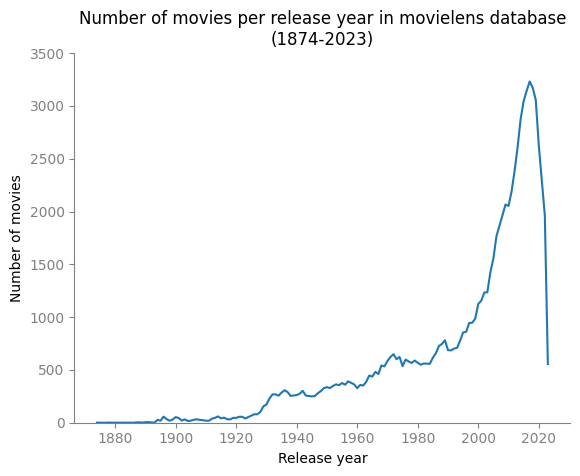

In [15]:
ax = sns.lineplot(x=years, y=films_per_year)
ax.set(
    ylabel="Number of movies",
    xlabel="Release year",
    title="Number of movies per release year in movielens database\n(1874-2023)",
    ylim=(0, 3500),
)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(colors="gray")

### e)

In [16]:
# make lists with movieIds and number of ratings
rated_movieIds = df_ratings["movieId"].value_counts().index.to_numpy()
number_ratings = df_ratings["movieId"].value_counts().to_numpy()

# make dataframe out of lists
df_ratings_per_movie = pd.DataFrame({"movieId": rated_movieIds, "ratings": number_ratings})
df_ratings_per_movie.head()

,movieId,ratings
0,318,122296
1,356,113581
2,296,108756
3,2571,107056
4,593,101802


In [17]:
# sort dataframe by movieId
df_ratings_per_movie = df_ratings_per_movie.sort_values("movieId", ignore_index=True)
df_ratings_per_movie.head(10)

,movieId,ratings
0,1,76813
1,2,30209
2,3,15820
3,4,3028
4,5,15801
5,6,31850
6,7,15596
7,8,1584
8,9,4563
9,10,34942


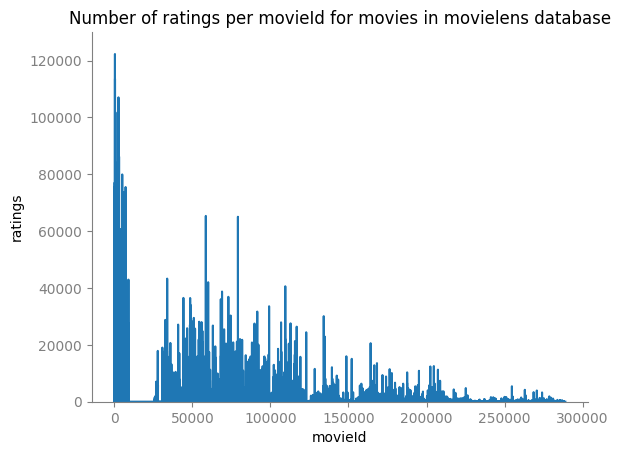

In [18]:
# barplot did not work, maybe too many values?
ax = sns.lineplot(df_ratings_per_movie, x="movieId", y="ratings")
ax.set(
    title="Number of ratings per movieId for movies in movielens database",
    ylim=(0, 130000),
)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(colors="gray")

### f)

In [19]:
# lists with titles and average ratings for top 10 most rated movies
title = [df_movies[df_movies["movieId"] == m]["title"].values[0] for m in most_rated]
avg_rating = [round(df_ratings[df_ratings["movieId"] == m]["rating"].mean(), 2) for m in most_rated]

title, avg_rating

(['Shawshank Redemption, The (1994)',
  'Forrest Gump (1994)',
  'Pulp Fiction (1994)',
  'Matrix, The (1999)',
  'Silence of the Lambs, The (1991)',
  'Star Wars: Episode IV - A New Hope (1977)',
  'Fight Club (1999)',
  "Schindler's List (1993)",
  'Jurassic Park (1993)',
  'Star Wars: Episode V - The Empire Strikes Back (1980)'],
 [4.42, 4.07, 4.19, 4.16, 4.15, 4.09, 4.24, 4.24, 3.69, 4.12])

C:\Users\Erik\AppData\Local\Temp\ipykernel_2592\2892602837.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(title, rotation=90)


[Text(0, 0, 'Shawshank Redemption, The (1994)'),
 Text(1, 0, 'Forrest Gump (1994)'),
 Text(2, 0, 'Pulp Fiction (1994)'),
 Text(3, 0, 'Matrix, The (1999)'),
 Text(4, 0, 'Silence of the Lambs, The (1991)'),
 Text(5, 0, 'Star Wars: Episode IV - A New Hope (1977)'),
 Text(6, 0, 'Fight Club (1999)'),
 Text(7, 0, "Schindler's List (1993)"),
 Text(8, 0, 'Jurassic Park (1993)'),
 Text(9, 0, 'Star Wars: Episode V - The Empire Strikes Back (1980)')]

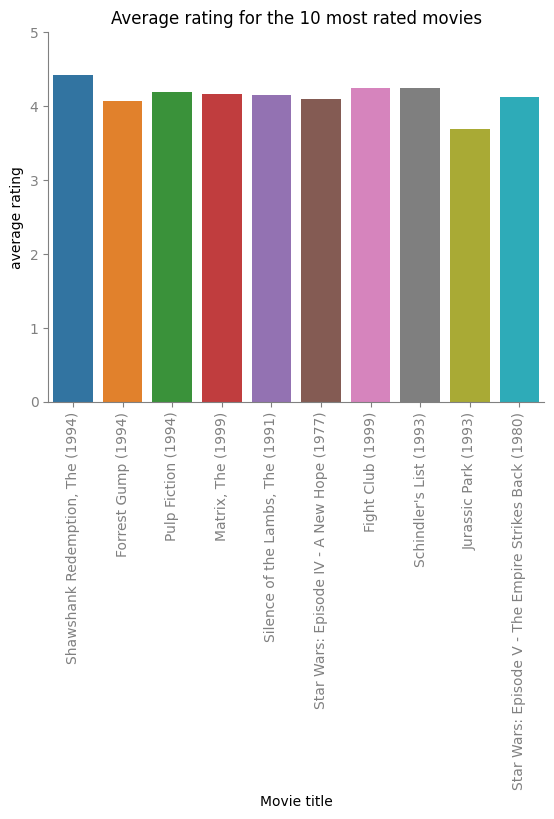

In [54]:
ax = sns.barplot(x=title, y=avg_rating, hue=title)
ax.set(
    ylabel="average rating",
    xlabel="Movie title",
    title="Average rating for the 10 most rated movies",
    ylim=(0, 5)
)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(colors="gray")
ax.set_xticklabels(title, rotation=90)

## 1.2 Skapa gles matris

Jag bestämde mig för att det verkade vettigt att först sortera bort användare och filmer som gett, respektive fått, få ratings

In [21]:
# suggested sorting by treshold of value counts from https://stackoverflow.com/questions/67006008/pandas-how-to-get-the-value-counts-above-a-threshold
# made a treshold to only include ratings from userIds with a combined 50 ratings or more
df_ratings_users = df_ratings[df_ratings.groupby("userId")["userId"].transform('size')>50]
df_ratings_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30064010 entries, 0 to 33832161
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 573.4 MB


In [22]:
# a treshold of at least 1000 ratings seemed to still include a solid amount of movies
df_ratings_adjusted = df_ratings_users[df_ratings_users.groupby("movieId")["movieId"].transform('size')>1000]
df_ratings_adjusted["movieId"].unique().shape, df_ratings_adjusted.shape

((4352,), (26613821, 3))

In [23]:
# how to make a mask to filter database from: https://saturncloud.io/blog/how-to-select-rows-from-a-dataframe-based-on-list-values-in-a-column-in-pandas/
# mask used to filter movie database to only include movies with movieIds present in adjusted rating database
mask = df_movies["movieId"].isin(df_ratings_adjusted["movieId"].unique())

df_movies_adjusted = df_movies[mask].reset_index(drop=True)
df_movies_adjusted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  4352 non-null   int32 
 1   title    4352 non-null   object
dtypes: int32(1), object(1)
memory usage: 51.1+ KB


In [24]:
# pivot table made with adjusted ratings database 
movies_users=df_ratings_adjusted.pivot(index='movieId', columns='userId', values='rating').fillna(0)

In [25]:
movies_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4352 entries, 1 to 279812
Columns: 128774 entries, 1 to 330975
dtypes: float32(128774)
memory usage: 2.1 GB


In [26]:
# matrix made from pivot table
mat_movies_users=csr_matrix(movies_users.values)

## 1.3 Recommender system

Det logiska fel jag upptäckte i videon är att när han skapar sin pivottabell
så har den ett annorlunda antal rader jämfört med dataframe för filmer. Detta
beror förmodligen på att dataframe för filmer innehåller ett antal filmer som
inte har någon rating och därför inte dyker upp i dataframe för ratings samt 
saknas när han använder movieId som index för sin pivottabell. I sin tur
innebär det att från och med indexet för den första filmen som existerar endast
i film dataframen så blir det en missanpassning mellan denna och den glesa matrisen.
Det är detta som orsakar att han får "'night Mother" som första resultat när han
söker efter liknande filmer till "Toy Story", den faktiska filmen som modellen
vill peka mot är egentligen "Toy Story 2" som har index 2353 i matrisen men 2355
i dataframen. I min version så har jag filtrerat för att endast inkludera filmer
som har ratings och stöter därför inte på samma problem.

In [27]:
# model for knn, I found euclidean to give better results than cosine generally
model_knn = NearestNeighbors(metric="euclidean", algorithm="brute", n_neighbors=20)

In [28]:
# slightly adjusted recommender function where it now won't print out any of the details of the search movie amongst similar movies
def recommender(idx, data, model, n_recommendations=5):
    model.fit(data)
    # idx = process.extractOne(movie_name, df_movies_adjusted["title"])[2]
    print("Movie Selected: ", df_movies_adjusted["title"][idx], "Index: ", idx)
    print(
        "--------------------------------\nSearching for recommendations...\n--------------------------------"
    )
    distances, indices = model.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    print(f"{n_recommendations} movies most similar to '{df_movies_adjusted['title'][idx]}' according to user reviews:")
    for i, d in zip(indices, distances):
        for index, distance in zip(i, d):
            if index != idx:
                print(
                    f"{df_movies_adjusted['title'][index]}, distance: {round(distance)}"
                )


# recommender("Doom (2005)", mat_movies_users, model_knn, 10)

In [29]:
# made separate function for choosing movie where you can pick 1 of 5 most likely options based on user input (didn't bother with error handling)
def choose_movie():
    user_input = input("Please enter the name of a movie:")
    choices = process.extract(user_input, df_movies_adjusted["title"], limit=5)
    print(f"Top 5 results for query: '{user_input}'")
    for c, i in zip(choices, range(1, 6)):
        print(i, c[0])
    user_input = input("Choose movie (1-5): ")
    return choices[int(user_input)-1][2]

### Test runs

In [30]:
movie_pick = choose_movie()
recommender(movie_pick , mat_movies_users, model_knn)

Top 5 results for query: 'rocky'
1 Rocky (1976)
2 Rocky II (1979)
3 Rocky III (1982)
4 Rocky IV (1985)
5 Rocky V (1990)
Movie Selected:  Rocky (1976) Index:  1041
--------------------------------
Searching for recommendations...
--------------------------------
5 movies most similar to 'Rocky (1976)' according to user reviews:
Rocky II (1979), distance: 473
Rocky III (1982), distance: 492
Rocky IV (1985), distance: 499
First Blood (Rambo: First Blood) (1982), distance: 509
Rocky V (1990), distance: 519


In [31]:
movie_pick = choose_movie()
recommender(movie_pick , mat_movies_users, model_knn)

Top 5 results for query: 'shrek'
1 Shrek (2001)
2 Shrek 2 (2004)
3 Shrek the Third (2007)
4 Swimming with Sharks (1995)
5 Shark Tale (2004)
Movie Selected:  Shrek the Third (2007) Index:  3184
--------------------------------
Searching for recommendations...
--------------------------------
5 movies most similar to 'Shrek the Third (2007)' according to user reviews:
Shrek Forever After (a.k.a. Shrek: The Final Chapter) (2010), distance: 218
Open Season (2006), distance: 239
Epic Movie (2007), distance: 240
Alvin and the Chipmunks (2007), distance: 241
Meet the Spartans (2008), distance: 242


In [32]:
movie_pick = choose_movie()
recommender(movie_pick , mat_movies_users, model_knn)

Top 5 results for query: 'dracula'
1 Dracula: Dead and Loving It (1995)
2 Dracula (Bram Stoker's Dracula) (1992)
3 Dracula (1931)
4 Dracula 2000 (2000)
5 Dracula Untold (2014)
Movie Selected:  Dracula (1931) Index:  1448
--------------------------------
Searching for recommendations...
--------------------------------
5 movies most similar to 'Dracula (1931)' according to user reviews:
Wolf Man, The (1941), distance: 171
Mummy, The (1932), distance: 189
Creature from the Black Lagoon, The (1954), distance: 191
House on Haunted Hill (1959), distance: 192
Exorcist II: The Heretic (1977), distance: 193


In [33]:
movie_pick = choose_movie()
recommender(movie_pick , mat_movies_users, model_knn)

Top 5 results for query: 'blades of glory'
1 Blades of Glory (2007)
2 Father of the Bride Part II (1995)
3 City of Lost Children, The (Cité des enfants perdus, La) (1995)
4 Bridges of Madison County, The (1995)
5 Beauty of the Day (Belle de jour) (1967)
Movie Selected:  Blades of Glory (2007) Index:  3168
--------------------------------
Searching for recommendations...
--------------------------------
5 movies most similar to 'Blades of Glory (2007)' according to user reviews:
Semi-Pro (2008), distance: 199
Epic Movie (2007), distance: 210
Date Movie (2006), distance: 210
Year One (2009), distance: 211
Meet the Spartans (2008), distance: 212


### a)

Mitt system fungerar genom att användaren får skriva in namnet på en film som en sökterm. Därefter används funktionen process.extract från modulen "fuzzywuzzy" för att hämta ut och lista 5 resultat från en dataframe med filmer som bäst matchar söktermen. Användaren kan därpå välja en av dessa 5 filmer varpå dess index plockas för att hitta andra filmer som ska likna denna baserat på användarratings. Indexet som matchar det för samma film i en gles matris med användare och ratings används då för att jämföra avstånd från denna gentemot alla andra filmer som punkter i en NearestNeighbor modell och plocka ut index och avstånd för ett antal mest närliggande punkter via funktionen kneighbors. De utplockade indexen matchas sedan återigen mot dataframen med filmer för att få ut filmtitlar som listas upp i ordning efter vilken som beräknades ha kortast avstånd till den tidigare valda filmen.

### b) 

Vanligtvis är rekommenderarsystem någon typ av artificiell intelligens och/eller algoritm som används för ge förslag till användare baserat på olika kriterier. Systemen kan sedan använda data från hur användare interagerar med dem för att vidare tränas och få en förståelse för preferenser och egenskaper hos dessa. Denna fördjupade kunskap gör att systemen ofta kan ge förslag och rekommendationer på en väldigt personlig nivå vilket ofta kan vara gynnande. Hur och vilken data som samlas in kan variera beroende på vilken typ av rekommendationer som ska ges, för en hemsida som Youtube skulle det exempelvis kunna vara vilka videor användare ger en "like" eller "dislike" till.

Det finns många olika exempel på typer av rekommenderarsystem, några av dem kan kategoriseras som: 

"Collaborative Filtering" jämfor preferenser och intressen mellan stora mängder användare samt tidigare beteenden hos dessa för att förutspå framtida interaktioner. Tanken med detta är att användare som liknar varandra och visat liknande beteende bör vara mottagliga för liknande förslag.

"Content Filtering" använder egenskaper hos det som rekommenderas för att jämföra dessa mot saker som användare har visat intresse för tidigare. Exempelvis så skulle en film från en specifik genre kunna rekommenderas om användaren tidigare sett många sådana filmer.

"Context filtering" använder information om den kontext användare befinner sig i. Till exempelvis vilken tid på dagen det är, var användaren befinner sig, vilken typ av enhet som används osv. Därmed så får användare mer liknande rekommendationer beroende på vilka kontextuella kriterier de delar.

Mer komplicerade system kan även använda kombinationer av dessa.

Många stora företag använder rekommenderarsystem för att mer effektivt kunna föreslå produkter för sina användare. På grund av lönsamheten av detta så sker det ett ständigt arbete för att förbättra och utveckla dessa system vidare.

Källor:

https://www.nvidia.com/en-us/glossary/recommendation-system/

https://medium.com/@khang.pham.exxact/what-are-recommendation-systems-6bb5036042db